The goal of this notebook is to verify the formulas obtained for the marginal Shapley values and TreeSHAP for two simple trees appearing in Example 3.1 of the paper. 

In [1]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import graphviz

import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

import shap

In [2]:
import catboost
catboost.__version__
#CatBoost version=0.21

'0.21'

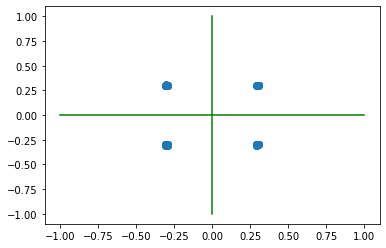

In [3]:
#Generating and visualizing the data
random.seed(5)
X=np.zeros([100,2])

for i in range(0,30):
    X[i][0]=0.02*(random.random()-0.5)-0.3
    X[i][1]=0.02*(random.random()-0.5)-0.3
for i in range(30,55):
    X[i][0]=0.02*(random.random()-0.5)+0.3
    X[i][1]=0.02*(random.random()-0.5)-0.3
for i in range(55,80):
    X[i][0]=0.02*(random.random()-0.5)-0.3
    X[i][1]=0.02*(random.random()-0.5)+0.3
for i in range(80,100):
    X[i][0]=0.02*(random.random()-0.5)+0.3
    X[i][1]=0.02*(random.random()-0.5)+0.3

plt.plot((-1,1),(0,0),'g')
plt.plot((0,0),(-1,1),'g')
plt.scatter(X[:,0],X[:,1])
plt.show()

In [4]:
#Values for the response variable
y=np.zeros([100,1])
for i in range(0,100):
    if X[i][1]<0:
        y[i]=1
    elif X[i][0]<0:
        y[i]=2
    else:
        y[i]=3

We start we the asymmetric tree. 

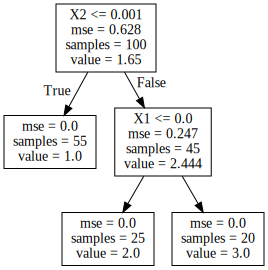

In [5]:
dt=DecisionTreeRegressor(random_state=1)
dt.fit(X,y)

import graphviz
tree.export_graphviz(dt,feature_names=["X1","X2"],out_file="tree.dot")

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [6]:
#Computing TreeSHAP feature attributions directly
p1=0.55            #(=p1l+p1r)
p1l=0.3            #(the probability of ending up at the bottom left square)
p1r=0.25           #(the probability of ending up at the bottom right square)
p2=0.25            #(the probability of ending up at the top left square)
p3=0.2             #(the probability of ending up at the top right square)
c1=1               #(leaf value for the bottom squares)   
c2=2               #(leaf value for the top left square)
c3=3               #(leaf value for the top right square)
mean=p1*c1+p2*c2+p3*c3

def TreeSHAP(X):                                #Computing TreeSHAP feature attribution for X_1 directly
    if X[1]<0 and X[0]<0:                       #(Compare with Table 1 in the paper.)
        difference=(p2+p3)*(c2-c1)                   
    elif X[1]<0 and X[0]>0:
        difference=(p2+p3)*(c3-c1)
    elif X[0]<0:
        difference=p1*c1+(p2+p3)*c2-(p2*c2+p3*c3)/(p2+p3)
    else:
        difference=p1*c1+(p2+p3)*c3-(p2*c2+p3*c3)/(p2+p3)
    return 0.5*(difference+dt.predict(X.reshape(1,2))-mean)     

def Marginal(X):
    if X[1]<0 and X[0]<0:
        difference=(p2+p3)*(c2-c1)                   
    elif X[1]<0 and X[0]>0:
        difference=(p2+p3)*(c3-c1)
    elif X[0]<0:
        difference=(c1-c2)*p1+(c2-c3)*(p1r+p3)
    else:
        difference=(c1-c3)*p1+(c3-c2)*(p1l+p2)
    return 0.5*(difference+dt.predict(X.reshape(1,2))-mean)  

In [7]:
explainer=shap.TreeExplainer(dt,feature_perturbation="tree_path_dependent")
treeshap_values=explainer.shap_values(X)

explainer=shap.TreeExplainer(dt,feature_perturbation="interventional",data=X)
marginal_values=explainer.shap_values(X)

In [9]:
#We see that the output of SHAP package agrees with the our direct computation. 
i=random.randint(0,99)
print(treeshap_values[i][0],TreeSHAP(X[i]))
print(marginal_values[i][0],Marginal(X[i]))

0.4027777777777778 [0.40277778]
0.4 [0.4]


Now a symmetric tree trained on the same data.

In [10]:
import catboost
from catboost import CatBoostRegressor
dt_symmetric=CatBoostRegressor(loss_function="RMSE",num_trees=1,depth=2,eval_metric="RMSE",random_seed=1)
dt_symmetric.fit(X,y)

dt_symmetric.save_model("mini_Regressor",format="json")
f=open("mini_Regressor")
dictionary=json.load(f)
dictionary['oblivious_trees'][0]

#The split that appears at the end has occured the first. So here the symmetric tree first splits w.r.t. X_1
#and then w.r.t. X_2
#Leaf values -0.2741379203467533 and -0.29545453461733734 correspond to the two halves of the upper rectangle and 
#they are close, as expected. 
#(Leaf values are different from the predicted values c1,c2 etc. which are given by scale*(leaf value)+bias.
#The scale and bias for the catboost model can be recovered from dt_symmetric.get_scale_and_bias().) 

Learning rate set to 0.5
0:	learn: 0.4664196	total: 46.2ms	remaining: 0us


{'leaf_values': [-0.2741379203467533,
  0.15312501043081284,
  -0.29545453461733734,
  0.5394230874685141],
 'leaf_weights': [26, 21, 30, 23],
 'splits': [{'border': 0.2927708029747009,
   'float_feature_index': 1,
   'split_index': 1,
   'split_type': 'FloatFeature'},
  {'border': -0.2926782965660095,
   'float_feature_index': 0,
   'split_index': 0,
   'split_type': 'FloatFeature'}]}

In [11]:
y_pred=dt_symmetric.predict(X)

#Computing TreeSHAP feature attributions directly. 
p1=0.55            #(=p1l+p1r)
p1l=0.30           #(the probability of ending up at the bottom left square)
p1r=0.25           #(the probability of ending up at the bottom right square)
p2=0.25            #(the probability of ending up at the top left square)
p3=0.20            #(the probability of ending up at the top right square)
c1=np.average(y_pred[:55])               
c2=np.average(y_pred[55:80])              
c3=np.average(y_pred[80:])              
mean=p1*c1+p2*c2+p3*c3

def TreeSHAP_symmetric(X):                            #Computing TreeSHAP feature attribution for X_1 directly
    if X[1]<0 and X[0]<0:                             #(Compare with Table 1 in the paper.)
        difference=(p2/(p1l+p2))*(c2-c1)                   
    elif X[1]<0 and X[0]>0:
        difference=(p3/(p1r+p3))*(c3-c1)
    elif X[0]<0:
        difference=(p1l/(p1l+p2))*c1+(p2/(p1l+p2))*c2-(p1l+p2)*c2-(p1r+p3)*c3
    else:
        difference=(p1r/(p1r+p3))*c1+(p3/(p1r+p3))*c3-(p1l+p2)*c2-(p1r+p3)*c3
    return 0.5*(difference+dt_symmetric.predict(X.reshape(1,2))-mean)     


In [12]:
explainer=shap.TreeExplainer(dt_symmetric,feature_perturbation="tree_path_dependent")
treeshap_values=explainer.shap_values(X)

# explainer=shap.TreeExplainer(dt_symmetric,feature_perturbation="interventional",data=X)
# marginal_values=explainer.shap_values(X)

In [16]:
#Comparing the outcomes (those from TreeSHAP with those manually computed)
i=random.randint(0,99)
print(treeshap_values[i][0],TreeSHAP_symmetric(X[i]))

0.1260498010634211 [0.14052094]
